In [68]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
import time 
%matplotlib inline

try:
    xrange = xrange
except:
    xrange = range

env = gym.make('CartPole-v0')

gamma = 0.99

start = time.time()
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [69]:
class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        hidden = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,a_size,activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))


In [84]:
tf.reset_default_graph() #Clear the Tensorflow graph.

myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8) #Load the agent.

total_episodes = 3000 #Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
    bestReward=[] 
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            #Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if d == True:
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
            #Update our running tally of scores.
        bestReward.append(np.max(total_reward[-100:]))
        if i % 100 == 0:
            
            print("Reached episode", i ,". Average reward in the last 100 episodes : ",np.mean(total_reward[-100:]))
        i += 1
end= time.time()


/mnt/c/Users/yasmi/DL/dl4cv/.venv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Reached episode 0 . Average reward in the last 100 episodes :  15.0
Reached episode 100 . Average reward in the last 100 episodes :  30.62
Reached episode 200 . Average reward in the last 100 episodes :  43.24
Reached episode 300 . Average reward in the last 100 episodes :  52.53
Reached episode 400 . Average reward in the last 100 episodes :  65.19
Reached episode 500 . Average reward in the last 100 episodes :  89.51
Reached episode 600 . Average reward in the last 100 episodes :  120.4
Reached episode 700 . Average reward in the last 100 episodes :  143.18
Reached episode 800 . Average reward in the last 100 episodes :  161.42
Reached episode 900 . Average reward in the last 100 episodes :  177.13
Reached episode 1000 . Average reward in the last 100 episodes :  177.11
Reached episode 1100 . Average reward in the last 100 episodes :  180.86
Reached episode 1200 . Average reward in the last 100 episodes :  185.3
Reached episode 1300 . Average reward in the last 100 episodes :  187.34

Finished after :  73204.23506069183 s


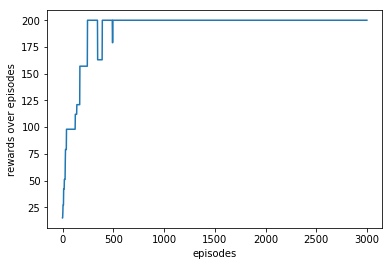

In [87]:
print( "Finished after : ", end-start, "s" )
plt.plot (bestReward )
plt.xlabel("episodes")
plt.ylabel("rewards over episodes" )
plt.show()

In [88]:
print(len(total_reward))
ravg=np.zeros(30)
tmp=0
j=0
for i in range (3000):
    tmp=tmp+total_reward[i]
    if i % 100 == 0 :
        ravg[j]=tmp/100
        tmp=0
        j=j+1
        

3000


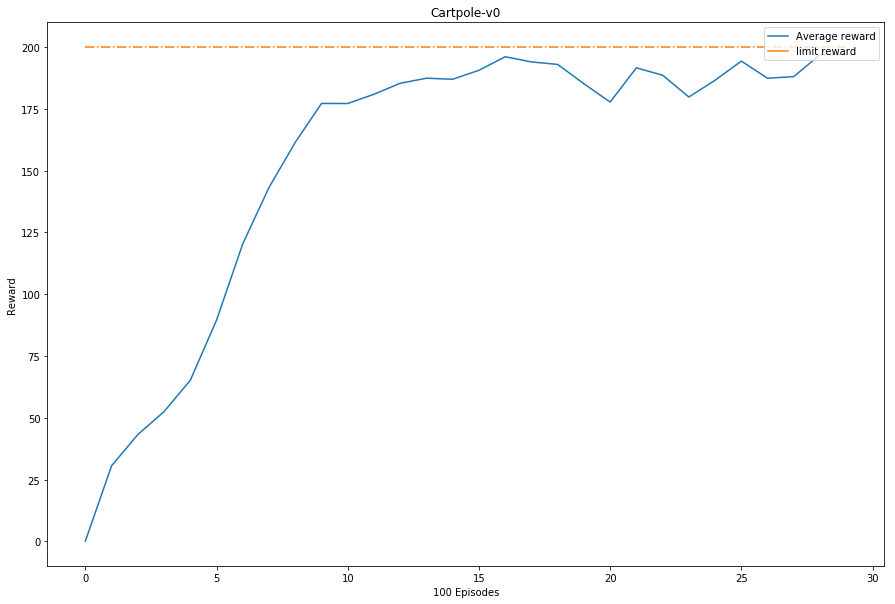

In [89]:
lim=np.zeros(30)+200
fig, ax = plt.subplots()

l1, = ax.plot(ravg)
#l2, = ax.plot(bestReward)
l3=ax.plot(lim,'-.')

ax.legend((l1, l2), ('Average reward', 'limit reward'), loc='upper right', shadow=False)
ax.set_xlabel('100 Episodes')
ax.set_ylabel('Reward')
ax.set_title('Cartpole-v0')
plt.gcf().set_size_inches(15, 10)
plt.savefig('CartPoleRL.png')
plt.show()